# Police prob to attend accident 1st approach

## May 2020

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, make_scorer
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score,  classification_report
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression







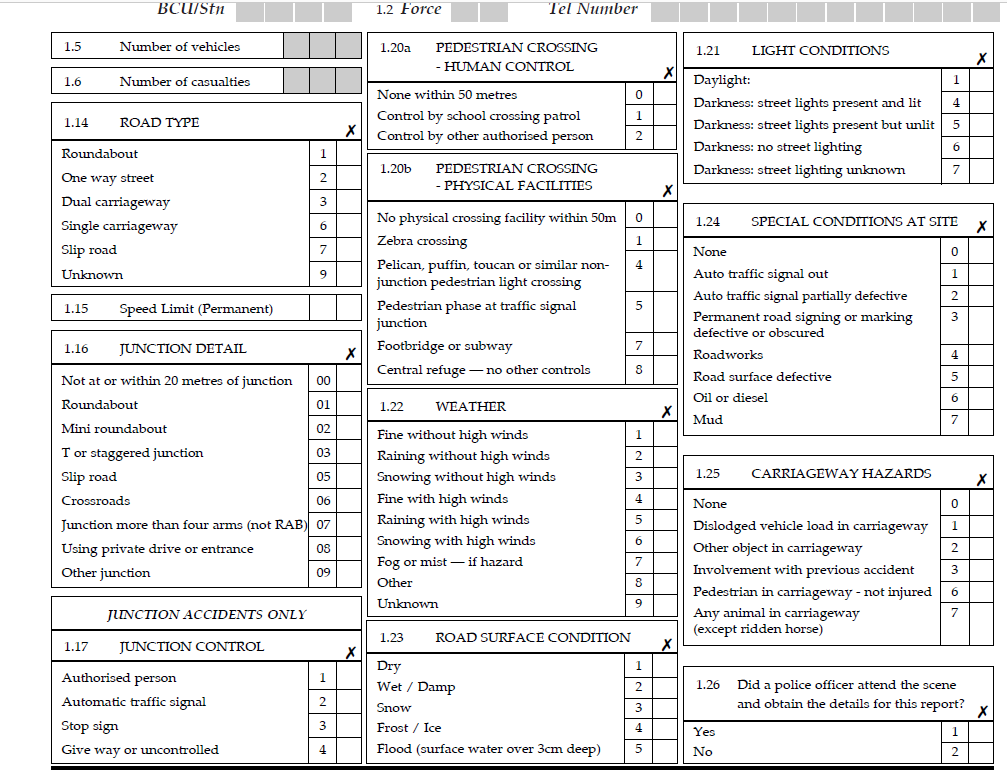

In [2]:
from IPython.display import Image
Image(filename='Info_on_vars.png') 

###### Data import

In [3]:
original_data = pd.read_csv('train_data.csv', delimiter=',', encoding='latin1')

In [4]:
data = original_data.copy()

### Taking a look to the target var

In [5]:
data.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([ 1,  2, -1], dtype=int64)

In [6]:
data['Did_Police_Officer_Attend_Scene_of_Accident']=data['Did_Police_Officer_Attend_Scene_of_Accident'].replace(2,0)
### TARGET VAR 
## Delete -1 value
data.drop(data.loc[data['Did_Police_Officer_Attend_Scene_of_Accident']==-1].index, inplace=True)

###### Fisrt look at dataframe

In [7]:
data.head() 

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201301BS70003,527060,177970,-0.171402,51.486361,1,2,2,1,02/01/2013,...,0,0,1,1,1,0,0,1,1,E01002844
1,201301BS70005,526900,178940,-0.173356,51.495115,1,3,1,2,04/01/2013,...,0,5,1,8,1,0,0,1,1,E01002821
2,201301BS70006,524240,181460,-0.210767,51.518353,1,3,1,1,07/01/2013,...,0,1,1,1,1,0,0,1,1,E01002878
3,201301BS70007,524320,181290,-0.209675,51.516808,1,3,2,1,10/01/2013,...,0,5,1,1,1,0,0,1,1,E01002831
4,201301BS70009,525450,178660,-0.194332,51.492922,1,3,2,1,04/01/2013,...,0,0,4,1,1,0,0,1,1,E01002851


### Location
Accidents are largely in densely populated roads/areas. No clear separation of police arrival on inspection

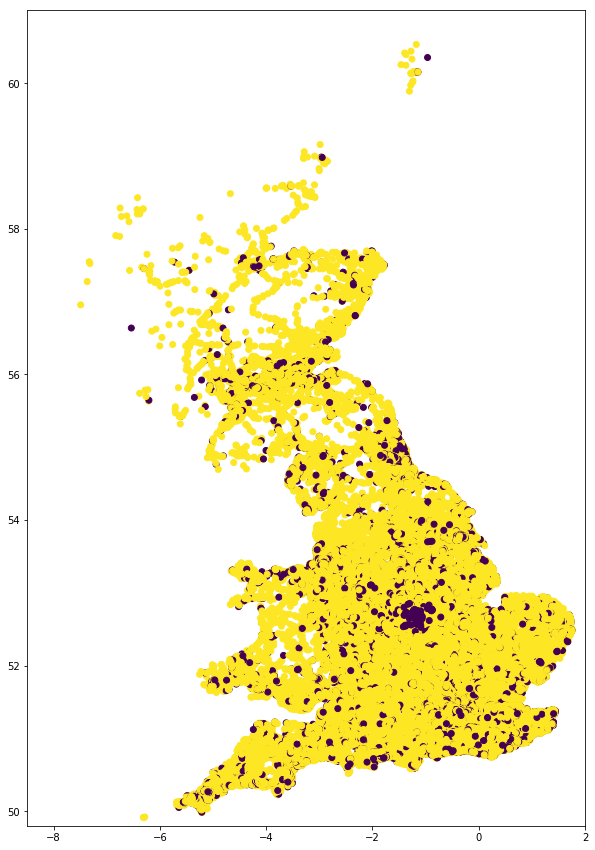

In [8]:
plt.figure(figsize=(10,15))
plt.scatter(data['Longitude'],data['Latitude'],c=data['Did_Police_Officer_Attend_Scene_of_Accident'])
plt.ylim((49.8,61))
plt.xlim((-8.5,2))
plt.show()

### Casualties


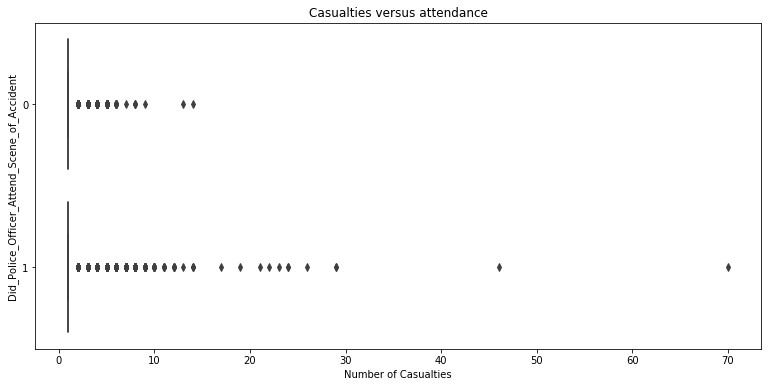

In [9]:
plt.figure(figsize=(13, 6))
sns.boxplot(y='Did_Police_Officer_Attend_Scene_of_Accident', x='Number_of_Casualties', data=data, orient='h')
plt.title('Casualties versus attendance')
plt.xlabel('Number of Casualties')
plt.show()

 ### Number of vehicles

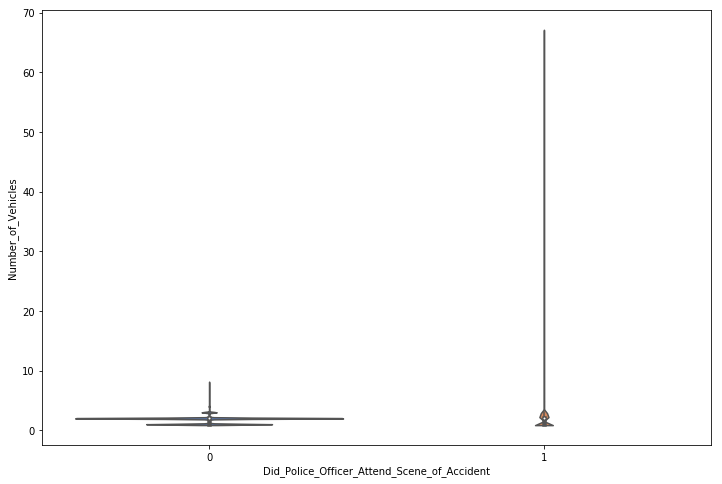

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.violinplot(x="Did_Police_Officer_Attend_Scene_of_Accident", y="Number_of_Vehicles",data=data, palette="muted")

 ### Urban or rural area

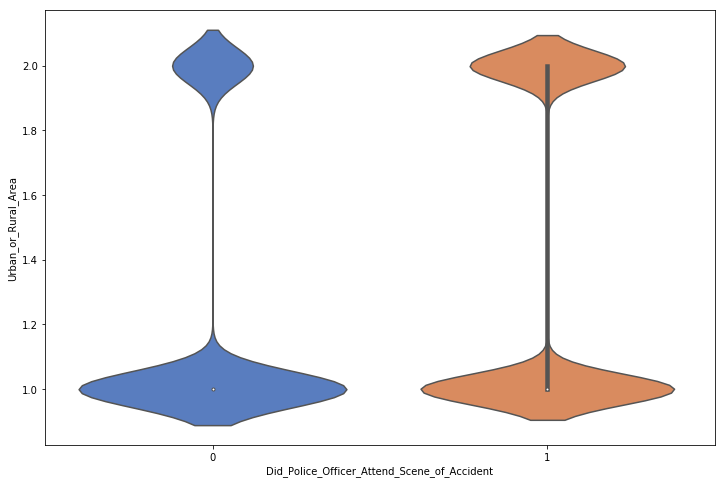

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.violinplot(x="Did_Police_Officer_Attend_Scene_of_Accident", y="Urban_or_Rural_Area",data=data, palette="muted")

### Correlation 

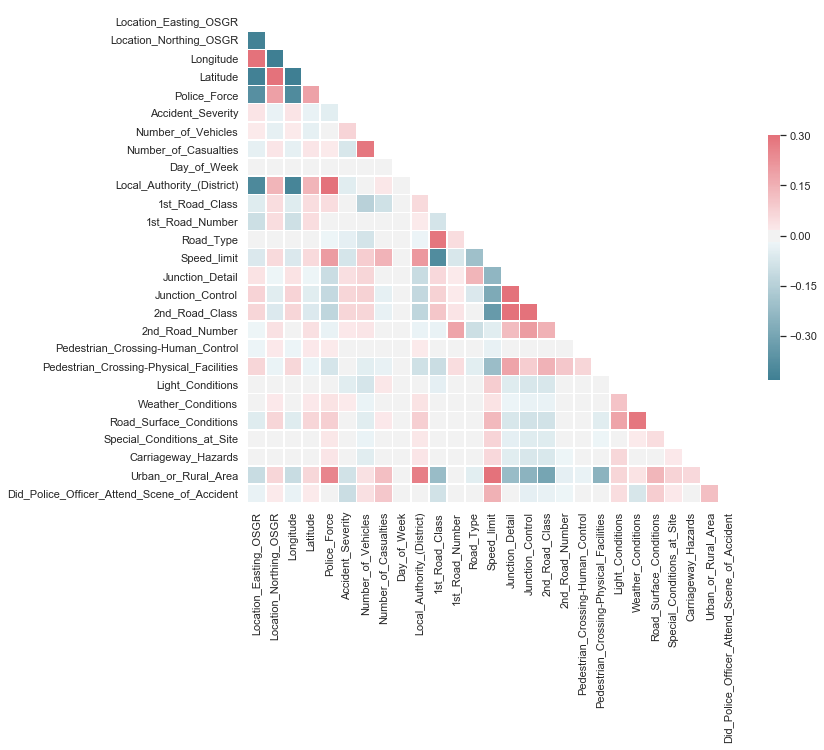

In [12]:

sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##### Show data types

In [13]:
data.dtypes

Accident_Index                                  object
Location_Easting_OSGR                            int64
Location_Northing_OSGR                           int64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                      int64
Junction_D

In [14]:
data.rename(columns={'Local_Authority_(District)':'Local_Authority_District',
                       'Local_Authority_(Highway)':'Local_Authority_Highway',

                     'Pedestrian_Crossing-Human_Control':'Pedestrian_Crossing_Human_Control',
                          'Pedestrian_Crossing-Physical_Facilities':'Pedestrian_Crossing_Physical_Facilities'}, 
                 inplace=True)

### Normalization ( min-max )

In [15]:
data['Weather_Conditions_norm'] = (data['Weather_Conditions'] - data['Weather_Conditions'].min()) / (data['Weather_Conditions'].max() - data['Weather_Conditions'].min())
data['Road_Surface_Conditions_norm'] = (data['Road_Surface_Conditions'] - data['Road_Surface_Conditions'].min()) / (data['Road_Surface_Conditions'].max() - data['Road_Surface_Conditions'].min())
data['Light_Conditions_norm'] = (data['Light_Conditions'] - data['Light_Conditions'].min()) / (data['Light_Conditions'].max() - data['Light_Conditions'].min())
#data['Carriageway_Hazards_norm'] = (data['Carriageway_Hazards'] - data['Carriageway_Hazards'].min()) / (data['Carriageway_Hazards'].max() - data['Carriageway_Hazards'].min())
#data['Special_Conditions_at_Site_norm'] = (data['Special_Conditions_at_Site'] - data['Special_Conditions_at_Site'].min()) / (data['Special_Conditions_at_Site'].max() - data['Special_Conditions_at_Site'].min())


### Standarization ( z-score normalization ) 

In [16]:
data['Weather_Conditions_std'] = (data['Weather_Conditions'] - data['Weather_Conditions'].mean()) / data['Weather_Conditions'].std()
data.drop('Weather_Conditions', axis=1, inplace=True)

data['Road_Surface_Conditions_std'] = (data['Road_Surface_Conditions'] - data['Road_Surface_Conditions'].mean()) / data['Road_Surface_Conditions'].std()
data.drop('Road_Surface_Conditions', axis=1, inplace=True)

data['Light_Conditions_std'] = (data['Light_Conditions'] - data['Light_Conditions'].mean()) / data['Light_Conditions'].std()
data.drop('Light_Conditions', axis=1, inplace=True)

#data['Carriageway_Hazards_std'] = (data['Carriageway_Hazards'] - data['Carriageway_Hazards'].mean()) / data['Carriageway_Hazards'].std()
#data['Special_Conditions_at_Site_std'] = (data['Special_Conditions_at_Site'] - data['Special_Conditions_at_Site'].mean()) / data['Special_Conditions_at_Site'].std()

### One-Hot encding for Speed Limit

In [17]:
#ohe = OneHotEncoder()
#X = ohe.fit_transform(data.Speed_limit.values.reshape(-1,1)).toarray()
#dfOneHot = pd.DataFrame(X, columns = ["Speed_Limit_"+str(int(i)) for i in range(X.shape[1])])
#data = pd.concat([data, dfOneHot], axis=1)


#data.drop('Speed_limit', axis=1, inplace=True)


### Label Encoding


In [18]:
encoder = LabelEncoder()
data['Local_Authority_Highway'] = encoder.fit_transform(data.Local_Authority_Highway.values)
#data['Accident_Index'] = encoder.fit_transform(data.Accident_Index.values)




### Transforming variables - Feature Engineering

In [19]:
###### TRASNFORMING VARIABLES 

### FUTURE VAR FINE_WEATHER ( values 4,1 -->1 , Resto -->0)
#data.loc[data['Weather_Conditions']==4, ['Weather_Conditions']] = 1
#data.loc[data['Weather_Conditions']>1, ['Weather_Conditions']] = 0
#data.rename(columns={'Weather_Conditions':'Fine_Weather'}, inplace=True)


### FUTURE VAR DRY_ROAD( values !=1 -->0 , Resto -->0)
#data.loc[data['Road_Surface_Conditions']!=1, ['Road_Surface_Conditions']] = 0
#data.rename(columns={'Road_Surface_Conditions':'Dry_Road'}, inplace=True)


### FUTURE VAR ENOUGH_LIGHT( values 4,1 -->1 , Resto -->0)
#data.loc[data['Light_Conditions']==4, ['Light_Conditions']] = 1
#data.loc[data['Light_Conditions']>1, ['Light_Conditions']] = 0
#data.rename(columns={'Light_Conditions':'Enough_Light'}, inplace=True)


### ACTUAL VAR CARRIAGE_HAZARDS( values >1-->1  , Resto -->0)
data.loc[data['Carriageway_Hazards']>1, ['Carriageway_Hazards']] = 1

### ACTUAL VAR SPECIAL_CONDITIONS_AT_SIGHT ( values >0-->1  , Resto -->0)
data.loc[data['Special_Conditions_at_Site']>0, ['Special_Conditions_at_Site']] = 1


### Extracting hour, month

In [20]:
data['hour'] = pd.to_datetime(data['Time'], format='%H:%M').dt.hour
data.dropna(subset=['hour'],  inplace=True)
data['hour'] = data['hour'].apply(np.int64)
data['month'] = pd.to_datetime(data['Date'], format='%d/%m/%Y' ).dt.month
data['Latitude'] = data['Latitude'].apply(np.int64)
data['Longitude'] = data['Longitude'].apply(np.int64)


In [21]:
data.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [22]:
data.hour.unique()

array([ 9,  8, 11, 10, 17, 15, 12, 18, 14, 16, 20,  7, 23, 19, 13, 21, 22,
        2,  6,  5,  1,  0,  3,  4], dtype=int64)

### Understanding thw distribution of the target variable ( weight )

In [23]:
data.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([1, 0], dtype=int64)

In [24]:
data['Did_Police_Officer_Attend_Scene_of_Accident'].value_counts()

1    113350
0     25301
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64

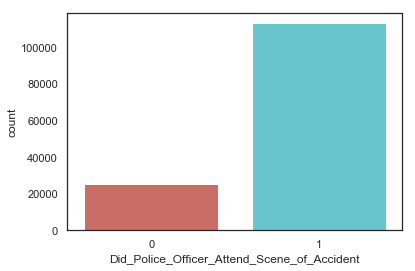

In [25]:
sns.countplot(x='Did_Police_Officer_Attend_Scene_of_Accident', data=data, palette='hls')
plt.show()

In [26]:
data.groupby('Did_Police_Officer_Attend_Scene_of_Accident').mean()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_District,...,Carriageway_Hazards,Urban_or_Rural_Area,Weather_Conditions_norm,Road_Surface_Conditions_norm,Light_Conditions_norm,Weather_Conditions_std,Road_Surface_Conditions_std,Light_Conditions_std,hour,month
Did_Police_Officer_Attend_Scene_of_Accident,,,,,,,,,,,,,,,,,,,,,
0,449896.267183,287418.351449,-0.974902,51.934548,30.450338,2.920715,1.760879,1.157504,4.147623,351.068653,...,0.012608,1.231730,0.098247,0.372969,0.130943,0.153985,-0.175434,-0.101826,13.579661,6.705348
1,443390.432228,295155.004764,-1.069510,52.008496,30.617830,2.816242,1.838068,1.361897,4.107084,350.899876,...,0.018571,1.379859,0.061160,0.395246,0.165462,-0.034364,0.039156,0.022769,13.524014,6.819885


 ### Searching null values
 

In [27]:
data.isna().sum()

Accident_Index                                    0
Location_Easting_OSGR                             0
Location_Northing_OSGR                            0
Longitude                                         0
Latitude                                          0
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                              0
Local_Authority_District                          0
Local_Authority_Highway                           0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

In [28]:
data.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_District,...,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Weather_Conditions_norm,Road_Surface_Conditions_norm,Light_Conditions_norm,Weather_Conditions_std,Road_Surface_Conditions_std,Light_Conditions_std,hour,month
count,138651.000000,1.386510e+05,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,...,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000,138651.000000
mean,444577.615372,2.937432e+05,-1.052246,51.995002,30.587266,2.835306,1.823983,1.324599,4.114482,350.930675,...,1.352828,0.817520,0.067928,0.391181,0.159163,0.000006,-0.000003,0.000033,13.534169,6.798985
std,95654.593897,1.608516e+05,1.243825,1.435904,25.449452,0.400938,0.726130,0.801203,1.914203,259.914188,...,0.477852,0.386241,0.196909,0.103813,0.277055,1.000017,1.000011,1.000019,5.069141,3.402259
min,66435.000000,1.029000e+04,-7.000000,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,-0.344970,-3.768187,-0.574461,0.000000,1.000000
25%,381540.000000,1.765900e+05,-2.000000,51.000000,7.000000,3.000000,1.000000,1.000000,2.000000,112.000000,...,1.000000,1.000000,0.000000,0.333333,0.000000,-0.344970,-0.557242,-0.574461,10.000000,4.000000
50%,448440.000000,2.490900e+05,-1.000000,52.000000,31.000000,3.000000,2.000000,1.000000,4.000000,340.000000,...,1.000000,1.000000,0.000000,0.333333,0.000000,-0.344970,-0.557242,-0.574461,14.000000,7.000000
75%,525870.000000,3.931200e+05,0.000000,53.000000,46.000000,3.000000,2.000000,1.000000,6.000000,531.000000,...,2.000000,1.000000,0.000000,0.500000,0.500000,-0.344970,1.048231,1.230270,17.000000,10.000000
max,655304.000000,1.183525e+06,1.000000,60.000000,98.000000,3.000000,67.000000,70.000000,7.000000,941.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,4.733606,5.864649,3.035001,23.000000,12.000000


In [29]:
data.drop('Time', axis=1, inplace=True)
data.drop('Date', axis=1, inplace=True)
data.drop('LSOA_of_Accident_Location', axis=1, inplace=True)

data.drop('Accident_Index', axis=1, inplace=True)
data.drop('Location_Easting_OSGR', axis=1, inplace=True)
data.drop('Location_Northing_OSGR', axis=1, inplace=True)
data.drop('1st_Road_Number', axis=1, inplace=True)
data.drop('2nd_Road_Number', axis=1, inplace=True)



#data.drop('Special_Conditions_at_Site', axis=1, inplace=True)
#data.drop('Carriageway_Hazards', axis=1, inplace=True)
data.drop('Pedestrian_Crossing_Human_Control', axis=1, inplace=True)

data.drop('Pedestrian_Crossing_Physical_Facilities', axis=1, inplace=True)
data.drop('Junction_Control', axis=1, inplace=True)


data.drop('Day_of_Week', axis=1, inplace=True)


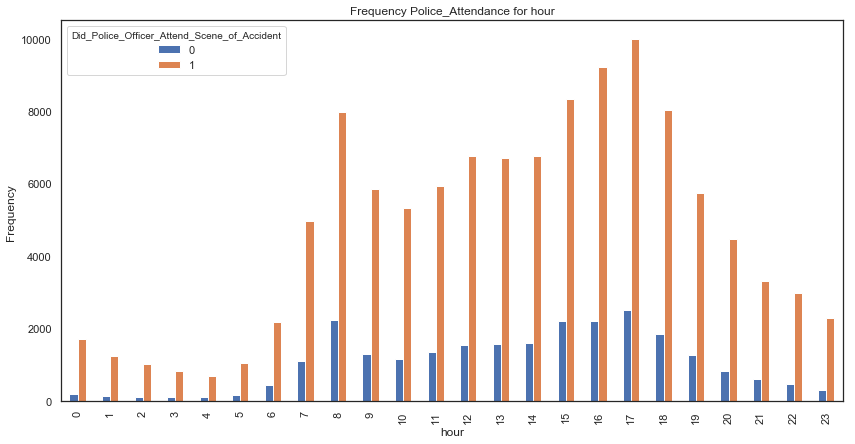

In [30]:
%matplotlib inline
pd.crosstab(data.hour,data.Did_Police_Officer_Attend_Scene_of_Accident).plot(kind='bar',figsize=(14, 7))
plt.title('Frequency Police_Attendance for hour')
plt.xlabel('hour')
plt.ylabel('Frequency ')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<function matplotlib.pyplot.show(*args, **kw)>

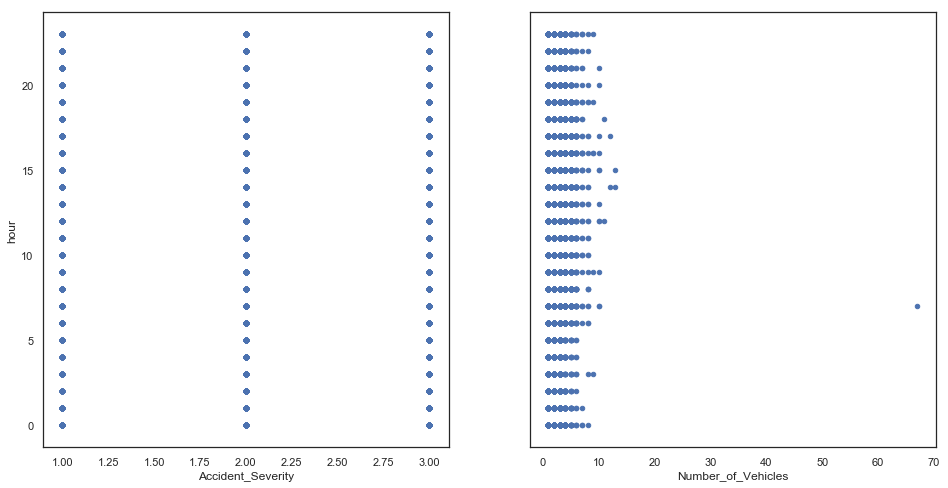

In [31]:
# visualize the relationship between the features and the response using scatterplots# visua 
fig, axs = plt.subplots(1, 2, sharey=True)
data.plot(kind='scatter', x='Accident_Severity', y='hour', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Number_of_Vehicles', y='hour', ax=axs[1])
#data.plot(kind='scatter', x='Fine_Weather', y='hour', ax=axs[2])
plt.show

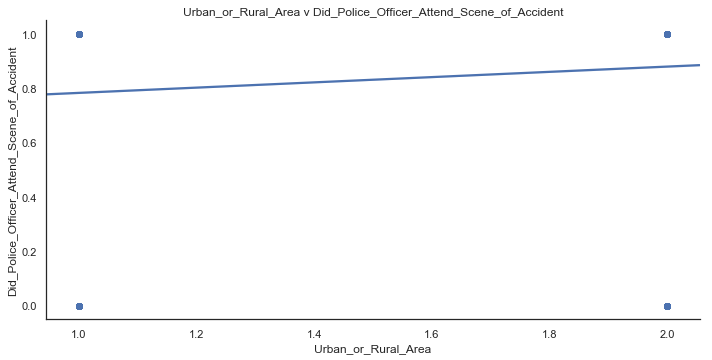

In [32]:
sns.lmplot(x='Urban_or_Rural_Area', y='Did_Police_Officer_Attend_Scene_of_Accident', data=data, size=5, aspect=2)
plt.title("Urban_or_Rural_Area v Did_Police_Officer_Attend_Scene_of_Accident")
# Show plot
plt.show()

<Figure size 432x288 with 0 Axes>

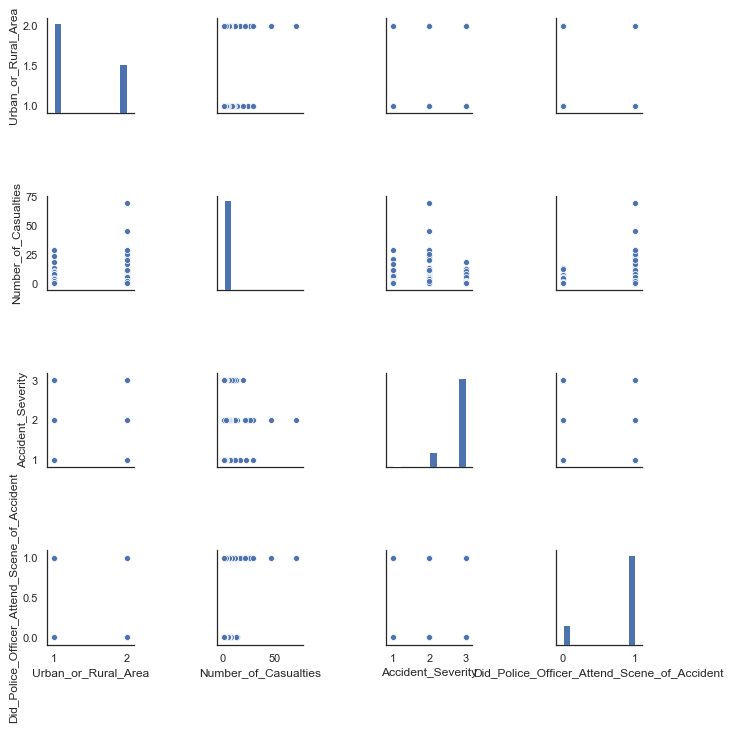

In [33]:
plt.figure()
sns.pairplot(data=data[["Urban_or_Rural_Area",
                        "Number_of_Casualties",
                        "Accident_Severity",
                        "Did_Police_Officer_Attend_Scene_of_Accident"
                                              ]])

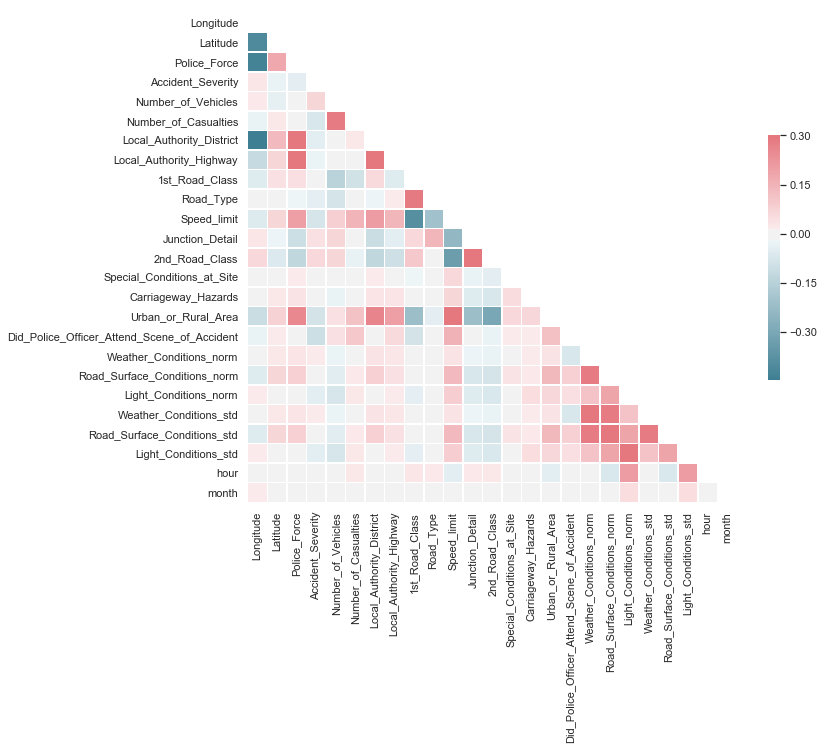

In [34]:

sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
data.drop('Latitude', axis=1, inplace=True)
data.drop('Longitude', axis=1, inplace=True)

In [36]:
#!wget https://geoportal.statistics.gov.uk/Docs/Names%20and%20Codes/Lower_layer_super_output_areas_\(E+W\)_2001_Names_and_Codes.zip

### KNN Regressor

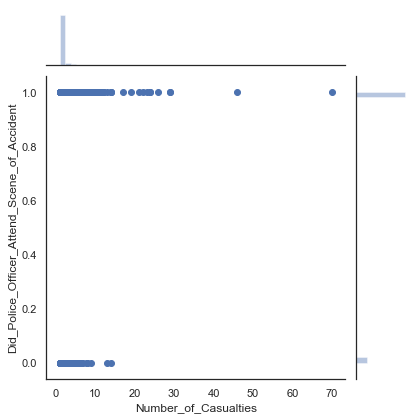

In [37]:
sns.jointplot(data=data, x='Number_of_Casualties', y='Did_Police_Officer_Attend_Scene_of_Accident');

In [38]:
X_KNN = data['Number_of_Casualties'].values.reshape(-1, 1)
Y_KNN = data['Did_Police_Officer_Attend_Scene_of_Accident'].values.reshape(-1, 1)

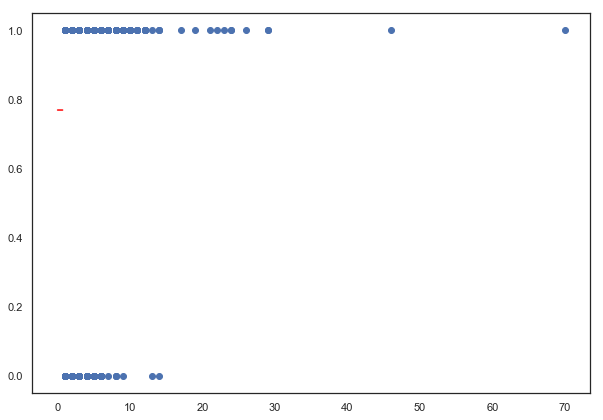

In [39]:
model = KNeighborsRegressor(n_neighbors=13, weights='uniform')
model.fit(X_KNN, Y_KNN)
test_values = np.arange(0, .7, step=1e-5)
test_predictions = model.predict(test_values.reshape(-1, 1))
plt.figure(figsize=(10, 7))
plt.plot(test_values, test_predictions, color='red')
plt.scatter(X_KNN, Y_KNN);

### KNN CLASSIFIER


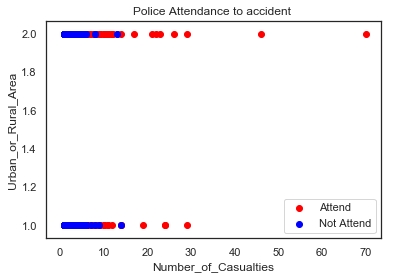

In [40]:
# Look at our data.
plt.scatter(
    data[data['Did_Police_Officer_Attend_Scene_of_Accident'] == 1].Number_of_Casualties,
    data[data['Did_Police_Officer_Attend_Scene_of_Accident'] == 1].Urban_or_Rural_Area,
    color='red'
)
plt.scatter(
    data[data['Did_Police_Officer_Attend_Scene_of_Accident'] == 0].Number_of_Casualties,
    data[data['Did_Police_Officer_Attend_Scene_of_Accident'] == 0].Urban_or_Rural_Area,
    color='blue'
)
plt.legend(['Attend', 'Not Attend'])
plt.title('Police Attendance to accident ')
plt.xlabel('Number_of_Casualties')
plt.ylabel('Urban_or_Rural_Area')
plt.show()

In [41]:
neighbors = KNeighborsClassifier(n_neighbors=5)

X = data[['Number_of_Casualties', 'Urban_or_Rural_Area']]
Y = data.Did_Police_Officer_Attend_Scene_of_Accident

neighbors.fit(X,Y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [42]:

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[17, 10]]))
print(neighbors.predict_proba([[17, 10]]))

[1]
[[0.2 0.8]]


### TRAIN_TEST_SPLIT

In [43]:
y = data['Did_Police_Officer_Attend_Scene_of_Accident']
X = data.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis=1)


In [44]:
x_train, x_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.3, random_state=123)

 ## Logistic Regression

In [45]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [47]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  241  7505]
 [  101 33749]]


In [48]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.03      0.06      7746
           1       0.82      1.00      0.90     33850

   micro avg       0.82      0.82      0.82     41596
   macro avg       0.76      0.51      0.48     41596
weighted avg       0.80      0.82      0.74     41596



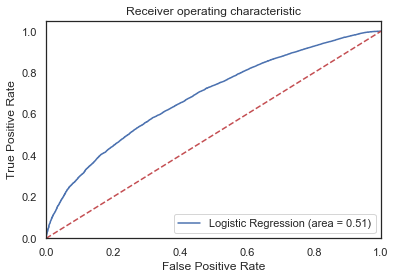

In [49]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators=10, random_state=123)

param_grid = {
        'max_depth' : [4,5,6,7],
        'min_samples_leaf' : [20,30,40,50],
        'max_features' : [0.05, 0.10, 0.20, 0.30, 0.40, 0.50] ,
        'class_weight' : [{1:0.20, 0:0.80}, {1:0.80, 0:0.85}]
            }

gs = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
gs.fit(x_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 5, 6, 7], 'min_samples_leaf': [20, 30, 40, 50], 'max_features': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 'class_weight': [{1: 0.2, 0: 0.8}, {1: 0.8, 0: 0.85}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [51]:
gs.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight={1: 0.2, 0: 0.8},
            criterion='gini', max_depth=7, max_features=0.4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

In [52]:
rf = gs.best_estimator_

In [53]:
pred = rf.predict(x_test)

In [54]:
metrics.accuracy_score(y_test, pred)

0.6827579574959131

In [55]:
pred_prob = rf.predict_proba(x_test)

In [56]:
fpr, tpr, _ = roc_curve(y_test, pred_prob[:, 1]) 
roc_auc = auc(fpr, tpr)
roc_auc 


0.7150926213024229

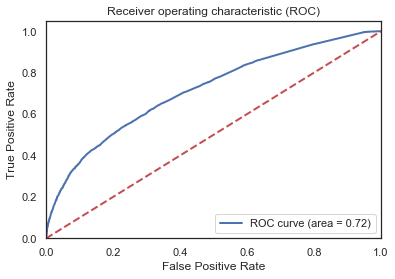

In [57]:
# Plot ROC curve with AUC score

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='b', lw=lw, 
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show() 

In [58]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

feature = x_train 
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];



Variable: Speed_limit          Importance: 0.262
Variable: Number_of_Casualties Importance: 0.1387
Variable: Number_of_Vehicles   Importance: 0.1306
Variable: Accident_Severity    Importance: 0.1009
Variable: Police_Force         Importance: 0.0646
Variable: Local_Authority_District Importance: 0.0548
Variable: Weather_Conditions_norm Importance: 0.0539
Variable: Weather_Conditions_std Importance: 0.0482
Variable: Local_Authority_Highway Importance: 0.0422
Variable: Urban_or_Rural_Area  Importance: 0.0281
Variable: Road_Type            Importance: 0.0173
Variable: Road_Surface_Conditions_std Importance: 0.016
Variable: Road_Surface_Conditions_norm Importance: 0.0107
Variable: 1st_Road_Class       Importance: 0.0079
Variable: 2nd_Road_Class       Importance: 0.006
Variable: hour                 Importance: 0.0055
Variable: Junction_Detail      Importance: 0.0044
Variable: month                Importance: 0.0033
Variable: Light_Conditions_std Importance: 0.0023
Variable: Light_Conditions

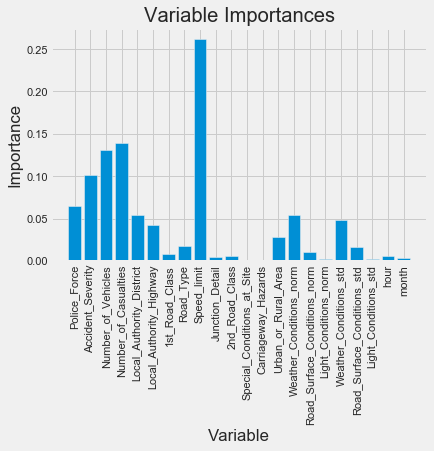

In [59]:

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [60]:
print(metrics.confusion_matrix(y_test, pred))


[[ 4571  3175]
 [10021 23829]]


In [61]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.31      0.59      0.41      7746
           1       0.88      0.70      0.78     33850

   micro avg       0.68      0.68      0.68     41596
   macro avg       0.60      0.65      0.60     41596
weighted avg       0.78      0.68      0.71     41596



### Final test

In [62]:
data_validation = pd.read_csv('test_data.csv', delimiter=',', encoding='latin1')

In [63]:
data_val = data_validation.copy()

In [64]:
data_val['Did_Police_Officer_Attend_Scene_of_Accident']=data_val['Did_Police_Officer_Attend_Scene_of_Accident'].replace(2,0)
data_val.drop(data_val.loc[data_val['Did_Police_Officer_Attend_Scene_of_Accident']==-1].index, inplace=True)

In [65]:
data_val.rename(columns={'Local_Authority_(District)':'Local_Authority_District',
                       'Local_Authority_(Highway)':'Local_Authority_Highway',

                     'Pedestrian_Crossing-Human_Control':'Pedestrian_Crossing_Human_Control',
                          'Pedestrian_Crossing-Physical_Facilities':'Pedestrian_Crossing_Physical_Facilities'}, 
                 inplace=True)

In [66]:
data_val['Weather_Conditions_norm'] = (data_val['Weather_Conditions'] - data_val['Weather_Conditions'].min()) / (data_val['Weather_Conditions'].max() - data_val['Weather_Conditions'].min())
data_val['Road_Surface_Conditions_norm'] = (data_val['Road_Surface_Conditions'] - data_val['Road_Surface_Conditions'].min()) / (data_val['Road_Surface_Conditions'].max() - data_val['Road_Surface_Conditions'].min())
data_val['Light_Conditions_norm'] = (data_val['Light_Conditions'] - data_val['Light_Conditions'].min()) / (data_val['Light_Conditions'].max() - data_val['Light_Conditions'].min())


### Standarization ( z-score normalization ) 

In [67]:
data_val['Weather_Conditions_std'] = (data_val['Weather_Conditions'] - data_val['Weather_Conditions'].mean()) / data_val['Weather_Conditions'].std()
data_val.drop('Weather_Conditions', axis=1, inplace=True)

data_val['Road_Surface_Conditions_std'] = (data_val['Road_Surface_Conditions'] - data_val['Road_Surface_Conditions'].mean()) / data_val['Road_Surface_Conditions'].std()
data_val.drop('Road_Surface_Conditions', axis=1, inplace=True)

data_val['Light_Conditions_std'] = (data_val['Light_Conditions'] - data_val['Light_Conditions'].mean()) / data_val['Light_Conditions'].std()
data_val.drop('Light_Conditions', axis=1, inplace=True)


### Label Encoding


In [68]:
encoder = LabelEncoder()
data_val['Local_Authority_Highway'] = encoder.fit_transform(data_val.Local_Authority_Highway.values)
#data['Accident_Index'] = encoder.fit_transform(data.Accident_Index.values)




### Transforming variables - Feature Engineering

In [69]:
###### TRASNFORMING VARIABLES 

### FUTURE VAR FINE_WEATHER ( values 4,1 -->1 , Resto -->0)
#data.loc[data['Weather_Conditions']==4, ['Weather_Conditions']] = 1
#data.loc[data['Weather_Conditions']>1, ['Weather_Conditions']] = 0
#data.rename(columns={'Weather_Conditions':'Fine_Weather'}, inplace=True)


### FUTURE VAR DRY_ROAD( values !=1 -->0 , Resto -->0)
#data.loc[data['Road_Surface_Conditions']!=1, ['Road_Surface_Conditions']] = 0
#data.rename(columns={'Road_Surface_Conditions':'Dry_Road'}, inplace=True)


### FUTURE VAR ENOUGH_LIGHT( values 4,1 -->1 , Resto -->0)
#data.loc[data['Light_Conditions']==4, ['Light_Conditions']] = 1
#data.loc[data['Light_Conditions']>1, ['Light_Conditions']] = 0
#data.rename(columns={'Light_Conditions':'Enough_Light'}, inplace=True)


### ACTUAL VAR CARRIAGE_HAZARDS( values >1-->1  , Resto -->0)
data_val.loc[data_val['Carriageway_Hazards']>1, ['Carriageway_Hazards']] = 1

### ACTUAL VAR SPECIAL_CONDITIONS_AT_SIGHT ( values >0-->1  , Resto -->0)
data_val.loc[data['Special_Conditions_at_Site']>0, ['Special_Conditions_at_Site']] = 1


### Extracting hour, month

In [70]:
data_val['hour'] = pd.to_datetime(data_val['Time'], format='%H:%M').dt.hour
data_val.dropna(subset=['hour'],  inplace=True)
data_val['hour'] = data_val['hour'].apply(np.int64)
data_val['month'] = pd.to_datetime(data_val['Date'], format='%d/%m/%Y' ).dt.month
data_val['Latitude'] = data_val['Latitude'].apply(np.int64)
data_val['Longitude'] = data_val['Longitude'].apply(np.int64)


In [73]:


data_val.drop('Time', axis=1, inplace=True)
data_val.drop('Date', axis=1, inplace=True)
data_val.drop('LSOA_of_Accident_Location', axis=1, inplace=True)

data_val.drop('Accident_Index', axis=1, inplace=True)
data_val.drop('Location_Easting_OSGR', axis=1, inplace=True)
data_val.drop('Location_Northing_OSGR', axis=1, inplace=True)
data_val.drop('1st_Road_Number', axis=1, inplace=True)
data_val.drop('2nd_Road_Number', axis=1, inplace=True)



data_val.drop('Pedestrian_Crossing_Human_Control', axis=1, inplace=True)

data_val.drop('Pedestrian_Crossing_Physical_Facilities', axis=1, inplace=True)
data_val.drop('Junction_Control', axis=1, inplace=True)


data_val.drop('Day_of_Week', axis=1, inplace=True)




In [74]:
y_val = data_val['Did_Police_Officer_Attend_Scene_of_Accident']
x_val = data_val.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis=1)


In [75]:
df_pred = pd.DataFrame(pred_prob)

In [76]:
df_pred.head()

,0,1
0,0.242998,0.757002
1,0.529301,0.470699
2,0.373836,0.626164
3,0.053048,0.946952
4,0.121467,0.878533


In [77]:
data_val['Prediction'] = df_pred[1]

In [78]:
Submission = pd.concat([data_validation['Accident_Index'], data_val['Prediction']], axis=1)
#Final_Submission = Submission[['Accident_Index', 'Prediction']]

#Submission = data_val[['Accident_Index', 'Prediction']]
#submision

In [79]:
Submission.head()

,Accident_Index,Prediction
0,201401BS70277,0.757002
1,201401BS70278,0.470699
2,201401BS70279,0.626164
3,201401BS70280,0.946952
4,201401BS70281,0.878533


In [80]:
Submission.to_csv('final_submission_CV_RandomForest.csv', index = False)